# 피쳐엔지니어링

In [2]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# 그래프에서 한글폰트 중 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

import warnings
warnings.filterwarnings('ignore')

In [3]:
train = pd.read_csv('./train.csv', parse_dates=["datetime"]) # ???
train.shape

(10886, 12)

In [4]:
test = pd.read_csv('./test.csv', parse_dates=["datetime"]) # ???
test.shape

(6493, 9)

In [5]:
# datetime을 쪼개는 년 월 일 등으로 쪼개는 과정

train["year"] = train["datetime"].dt.year
train["month"] = train["datetime"].dt.month
train["day"] = train["datetime"].dt.day
train["hour"] = train["datetime"].dt.hour
train["minute"] = train["datetime"].dt.minute
train["second"] = train["datetime"].dt.second
train["dayofweek"] = train["datetime"].dt.dayofweek  # 월화수목금토일 개수 새는 것

test["year"] = test["datetime"].dt.year
test["month"] = test["datetime"].dt.month
test["day"] = test["datetime"].dt.day
test["hour"] = test["datetime"].dt.hour
test["minute"] = test["datetime"].dt.minute
test["second"] = test["datetime"].dt.second
test["dayofweek"] = test["datetime"].dt.dayofweek  # 월화수목금토일 개수 새는 것


# Windspeed 에 0값이 많은 것을 확인. 
# 이것을 ML로 값 찾아서 수정해보기

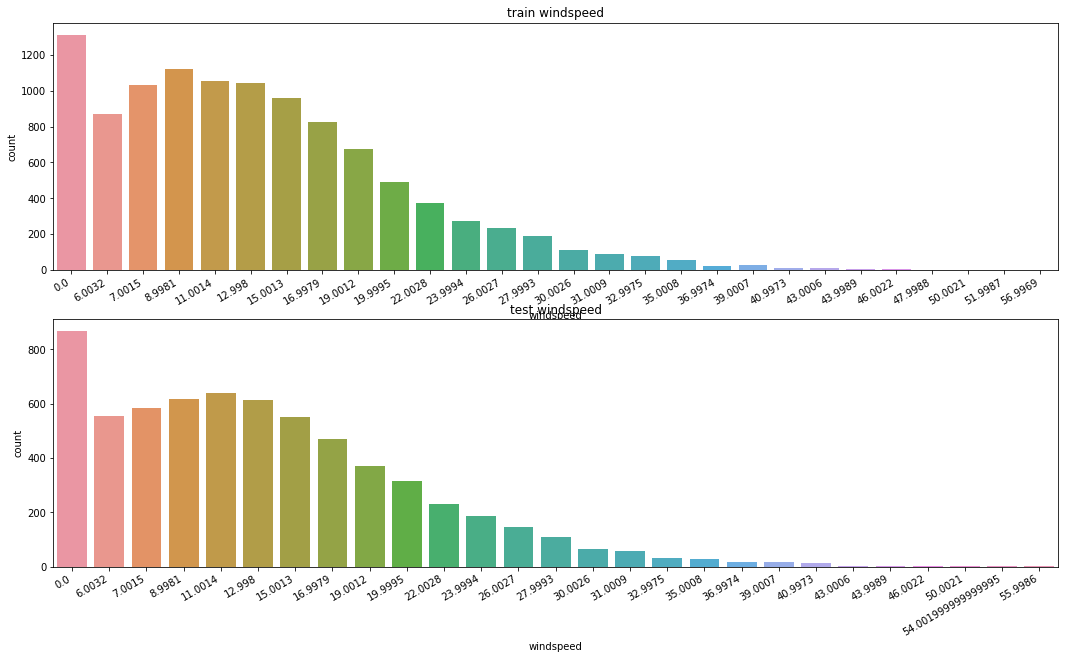

In [6]:
fig, axes = plt.subplots(nrows=2)
fig.set_size_inches(18,10)

plt.sca(axes[0])
plt.xticks(rotation=30, ha='right')
axes[0].set(ylabel="count", title="train windspeed")
sns.countplot(data=train, x="windspeed", ax=axes[0])

plt.sca(axes[1])
plt.xticks(rotation=30, ha='right')
axes[1].set(ylabel="count", title="test windspeed")
sns.countplot(data=test, x="windspeed", ax=axes[1])

- 평균을 구해 일괄적으로 넣어줄 수도 있지만, 예측의 정확도를 높이는 데 도움이 될 것 같진 않다.
-- 평균으로 넣어주는 방법
##### train.loc[train["windspeed"] == 0, "windspped"] = train["windspeed"].mean()

In [7]:
# 우선, 풍속이 0인 것과 아닌 것의 세트를 나누어 준다.
trainWind0 = train.loc[train['windspeed'] == 0]
trainWindNot0 = train.loc[train['windspeed'] != 0]
print(trainWind0.shape) # (1313, 19)
print(trainWindNot0.shape) # (9573, 19)


print(trainWindNot0)

(1313, 19)
(9573, 19)
                 datetime  season  holiday  workingday  weather   temp  \
5     2011-01-01 05:00:00       1        0           0        2   9.84   
10    2011-01-01 10:00:00       1        0           0        1  15.58   
11    2011-01-01 11:00:00       1        0           0        1  14.76   
12    2011-01-01 12:00:00       1        0           0        1  17.22   
13    2011-01-01 13:00:00       1        0           0        2  18.86   
14    2011-01-01 14:00:00       1        0           0        2  18.86   
15    2011-01-01 15:00:00       1        0           0        2  18.04   
16    2011-01-01 16:00:00       1        0           0        2  17.22   
17    2011-01-01 17:00:00       1        0           0        2  18.04   
18    2011-01-01 18:00:00       1        0           0        3  17.22   
19    2011-01-01 19:00:00       1        0           0        3  17.22   
20    2011-01-01 20:00:00       1        0           0        2  16.40   
21    2011-01-01

In [8]:
# ML로 예측해서 풍속 넣어준다.

from sklearn.ensemble import RandomForestClassifier

def predict_windspeed(data):
    
    # 풍속이 0인 것과 아닌 것을 나누어준다.
    dataWind0 = train.loc[data['windspeed'] == 0] # test set으로 쓰임.
    dataWindNot0 = train.loc[data['windspeed'] != 0] # train set으로 쓰임.
    
    # 풍속 예측에 쓰일 피처를 선택
    wCol = ['season', 'weather', 'temp', 'atemp', 'humidity', 'year','month']
    
    # 풍속이 0이 아닌 데이터들의 타입을 스트링으로 바꿔준다.
    dataWindNot0["windspeed"] = dataWindNot0["windspeed"].astype("str")
    
    rf_wind = RandomForestClassifier()
    
    # wCol 변수의 피처 값 바탕으로 풍속 학습
    rf_wind.fit(dataWindNot0[wCol], dataWindNot0["windspeed"])
    
    # 학습한 값을 바탕으로 풍속이 0으로 기록된 데이터(dataWind0)의 풍속을 예측.
    wind0Values = rf_wind.predict(X = dataWind0[wCol])  # X 값을 여기서 직접적으로 지정해준다 !
    
    # 예측된 값을 비교해보기 위해 예측한 값을 넣어 줄 데이터 프레임을 새로 만든다.
    predictWind0 = dataWind0
    predictWindNot0 = dataWindNot0
    
    # 값이 0으로 기록된 풍속에 대해 예측한 값을 넣어줌
    predictWind0["windspeed"] = wind0Values
    
    # 0과 0이 아닌 풍속 데이터프레임을 하나로 합쳐준다. 예측과 기존 셋을...
    data = predictWindNot0.append(predictWind0)
    
    # 풍속의 데이터타입을 float로 지정한다.
    data["windspeed"] = data["windspeed"].astype("float")
    
    data.reset_index(inplace=True)
    data.drop('index', inplace=True, axis=1)
    
    return data

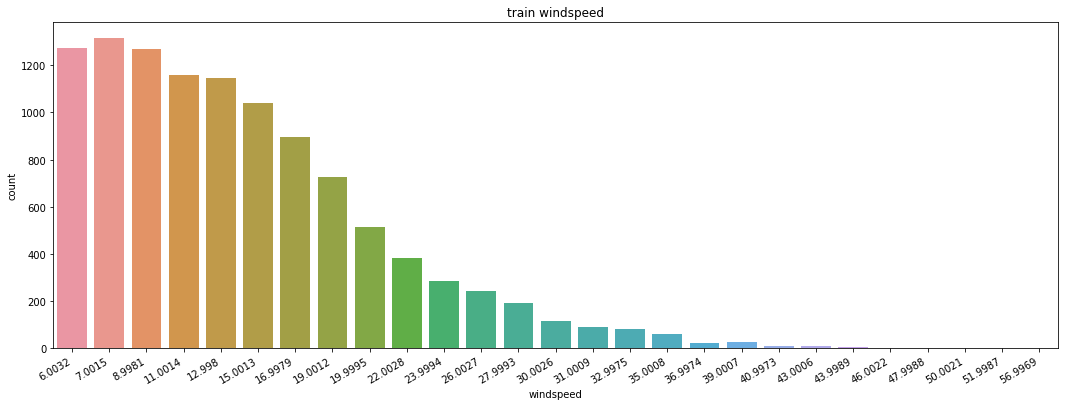

In [9]:
train = predict_windspeed(train)

fig, ax1 = plt.subplots()
fig.set_size_inches(18, 6)

plt.sca(ax1)
plt.xticks(rotation=30, ha='right')
ax1.set(ylabel='Count', title="train windspeed")
sns.countplot(data=train, x="windspeed", ax=ax1)

# 위와 같이 조절해서, 0값이 해소되었다 !

https://pbpython.com/categorical-encoding.html

# Feature Selection

- 신호와 잡음을 구별해야 한다. 이말은 곧,
- 피처가 많다고해서 무조건 좋은 성능을 내지 않는다.
- 피처를 하나씩 추가하고 변경해 가면서 성능이 좋지 않은 피처는 제거하도록 한다.

In [10]:
# 연속형 feature = ['temp', 'humidity', 'windspeed', 'atemp']
# 범주형 feature는 category로 구분을 한다는데 뭔 개소리인지 모르겠다.

categorical_feature_names = ['season','holiday','workingday','weather','dayofweek','month','year','hour']

for var in categorical_feature_names:
    train[var] = train[var].astype('category')
    test[var] = test[var].astype('category')

In [14]:
feature_names = ['season','weather','temp','atemp','humidity','windspeed','year','hour','dayofweek','holiday','workingday']

print(feature_names)

# feature_names 만 따로 모아서 리스트형 변수에 담음.

['season', 'weather', 'temp', 'atemp', 'humidity', 'windspeed', 'year', 'hour', 'dayofweek', 'holiday', 'workingday']


In [15]:
# 위의 피처 묶음으로 새로운 데이터셋 만듬.
# 피처를 딱 쓸 것들로만 간추린 것이다.
X_train = train[feature_names]

print(X_train.shape)
X_train.head()

(10886, 11)


,season,weather,temp,atemp,humidity,windspeed,year,hour,dayofweek,holiday,workingday
0,1,2,9.84,12.880,75,6.0032,2011,5,5,0,0
1,1,1,15.58,19.695,76,16.9979,2011,10,5,0,0
2,1,1,14.76,16.665,81,19.0012,2011,11,5,0,0
3,1,1,17.22,21.210,77,19.0012,2011,12,5,0,0
4,1,2,18.86,22.725,72,19.9995,2011,13,5,0,0


In [16]:
X_test = test[feature_names]

print(X_test.shape)
X_test.head()

(6493, 11)


,season,weather,temp,atemp,humidity,windspeed,year,hour,dayofweek,holiday,workingday
0,1,1,10.66,11.365,56,26.0027,2011,0,3,0,1
1,1,1,10.66,13.635,56,0.0000,2011,1,3,0,1
2,1,1,10.66,13.635,56,0.0000,2011,2,3,0,1
3,1,1,10.66,12.880,56,11.0014,2011,3,3,0,1
4,1,1,10.66,12.880,56,11.0014,2011,4,3,0,1


In [17]:
# y값(target값)은 count 값이다. 이것을 바탕으로 test의 count 값도 예측할것이다.

label_name = 'count'

y_train = train[label_name]

print(y_train.shape)
y_train.head()

(10886,)


0     1
1    36
2    56
3    84
4    94
Name: count, dtype: int64

# Score

# RMSLE 설명 및 구현 
과대평가 된 항목보다는 과소평가 된 항목에 패널티를 준다.

오차(Error)를 제곱(Square)해서 평균(Mean)한 값의 제곱근(Root) 으로 값이 작을 수록 정밀도가 높다.

0에 가까운 값이 나올 수록 정밀도가 높은 값이다.

Submissions are evaluated one the Root Mean Squared Logarithmic Error (RMSLE)

$$ \sqrt{\frac{1}{n} \sum_{i=1}^n (\log(p_i + 1) - \log(a_i+1))^2 } $$

- n is the number of hours in the test set
- p1 is your predicted count
- a1 is the actual count
- log(x) is the natural logarithm
- 좀 더 자세한 설명은 : RMSLE cost function

- 잔차(residual)에 대한 평균에 로그를 씌운 값이다. => 과대평가 된 항목보다 과소 평가 된 항목에 패널티를 주기위해

- 정답에 대한 오류를 숫자로 나타낸 값으로 값이 클 수록 오차가 크다는 의미다.
값이 작을 수록 오류가 적다는 의미를 나타낸다.


![title](./RMSLE.png)
이미지 출처 : 위키피디아 https://ko.wikipedia.org/wiki/로그

$$ \sqrt{\frac{1}{n} \sum_{i=1}^n (\log(p_i + 1) - \log(a_i+1))^2 } $$

In [22]:
from sklearn.metrics import make_scorer

def rmsle(predicted_values, actual_values):
    # 넘파이로 배열 형태로 바꿔준다.
    predicted_values = np.array(predicted_values)
    actual_values = np.array(actual_values)
    
    
    # 예측값과 실제 값에 1을 더하고 로그를 씌워준다.
    log_predict = np.log(predicted_values + 1)
    log_actual = np.log(actual_values + 1)
    
    
    # 위에서 계산한 예측값에서 실제값을 빼주고 제곱을 해준다.
    difference = log_predict = log_actual
    # difference = (log_predict - log_actual) ** 2
    difference = np.square(difference)
    
    
    # 평균을 낸다.
    mean_difference = difference.mean()
    
    
    # 마지막으로, 루트를 씌운다.
    score = np.sqrt(mean_difference)
    
    return score

rmsle_scorer = make_scorer(rmsle)
rmsle_scorer

make_scorer(rmsle)

# Cross Validation 교차 검증

- KFold, Cross_val_Score
- 일반화 성능을 측정하기 위해 데이터를 여러 번 반복해서 나누고 여러 모델을 학습한다

In [24]:
# kFold를 10겹으로 한다.

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

# RF 회귀모델 사용 예측 모델링

In [28]:
from sklearn.ensemble import RandomForestRegressor

max_depth_list = []

model = RandomForestRegressor(n_estimators=100,
                             n_jobs=-1,
                             random_state=0)
model

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                      oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

In [32]:
%time score = cross_val_score(model, X_train, y_train, cv=k_fold, scoring=rmsle_scorer)
score = score.mean()

# rmsle은 특성상 0에 근접할수록 좋은 데이터이다.
print("Score = {0:.5f}".format(score))

Wall time: 14.5 s
Score = 4.84593


In [37]:
model.fit(X_train, y_train)

predictions = model.predict(X_test)

print(predictions.shape)
predictions[0:10]

(6493,)


array([ 12.45,   4.88,   4.27,   3.51,   3.17,   6.41,  38.34, 105.46,
       236.54, 135.51])

[Text(0.5, 1.0, 'test')]

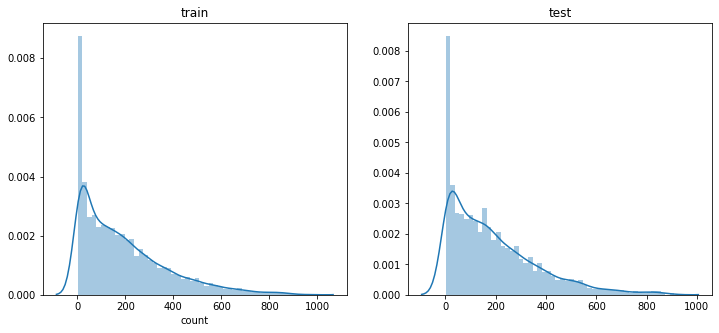

In [40]:
# 예측한 데이터를 시각화 해본다.
fig,(ax1, ax2) = plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sns.distplot(y_train, ax=ax1, bins=50)
ax1.set(title = "train")

sns.distplot(predictions, ax=ax2, bins=50)
ax2.set(title="test")

# Submit

In [41]:
submission = pd.read_csv('./sampleSubmission.csv')
submission

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0
5,2011-01-20 05:00:00,0
6,2011-01-20 06:00:00,0
7,2011-01-20 07:00:00,0
8,2011-01-20 08:00:00,0
9,2011-01-20 09:00:00,0


In [43]:
submission["count"] = predictions

print(submission.shape)
submission.head(50)

(6493, 2)


,datetime,count
0,2011-01-20 00:00:00,12.450000
1,2011-01-20 01:00:00,4.880000
2,2011-01-20 02:00:00,4.270000
3,2011-01-20 03:00:00,3.510000
4,2011-01-20 04:00:00,3.170000
5,2011-01-20 05:00:00,6.410000
6,2011-01-20 06:00:00,38.340000
7,2011-01-20 07:00:00,105.460000
8,2011-01-20 08:00:00,236.540000
9,2011-01-20 09:00:00,135.510000


In [45]:
submission.to_csv("./Score_{0:.5f}_submission.csv".format(score), index=False)

In [47]:
435/3501

0.12425021422450729